# Autoregressive Integrated Moving Average (ARIMA)

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
%matplotlib inline
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore")

Lets create a few functions first to ease our prediction process

In [2]:
#Funciton to do box cox transformation and differencing
def boxcox_diff(tsdf):
    #Doing Box cox transformation
    df_box=tsdf.copy()
    df_box.iloc[:,0],lamda=boxcox(tsdf.iloc[:,0].values) 
    #Doing the Differencing technique on box cox
    df_box_diff = df_box - df_box.shift() #1st order differencing
    df_box_diff = df_box_diff.fillna(0)
    return df_box_diff, lamda, df_box.iloc[0]

In [3]:
#Funciton to do inverse box cox transformation and differencing
def inv_boxcox_diff(tsdf,lamda,init):
    bdf_box=tsdf.copy()
    bdf=tsdf.copy()
    # Take cumulative sum 
    bdf_box_cumsum=tsdf.cumsum()
    # Adding the starting value of the original time series to make the shifting back correct after cumulative sum.
    bdf_box = init + bdf_box_cumsum
    #taking inverse box cox
    bdf.iloc[:,0]=round(inv_boxcox(bdf_box,lamda))
    return bdf

In [4]:
#Lets create a function for the prediction
def arima_predict(tsdf,p,d,q,summary=False):
    ts=tsdf.copy()
    #Bulding model & predicting
    model = ARIMA(ts, order=(p, d, q))  
    results_ARIMA = model.fit() 
    ts.iloc[:,0]=results_ARIMA.fittedvalues
    if summary: print(results_ARIMA.summary()) 
    return(ts)

### Load the data and do box cox transformation and differencing

In [5]:
#Refer Explanatory Data Analysis notebook to know more on this
df=pd.read_csv('SeaPlaneTravel.csv')
df.Month=pd.to_datetime(df.Month)
df.set_index('Month',inplace=True)
df.index = pd.DatetimeIndex(df.index).to_period('M')
#Doing Box cox transformation % differencing
df_box_diff,lam,init_val=boxcox_diff(df)
df_box_diff.head()

,#Passengers
Month,
2003-01,0.000000
2003-02,0.105332
2003-03,0.229069
2003-04,-0.047281
2003-05,-0.130824


In [6]:
#Testing inversion
bdf=inv_boxcox_diff(df_box_diff,lam,init_val)
bdf.head()

,#Passengers
Month,
2003-01,112.0
2003-02,118.0
2003-03,132.0
2003-04,129.0
2003-05,121.0


### Find out the p,q,d values to do the ARIMA forcasting

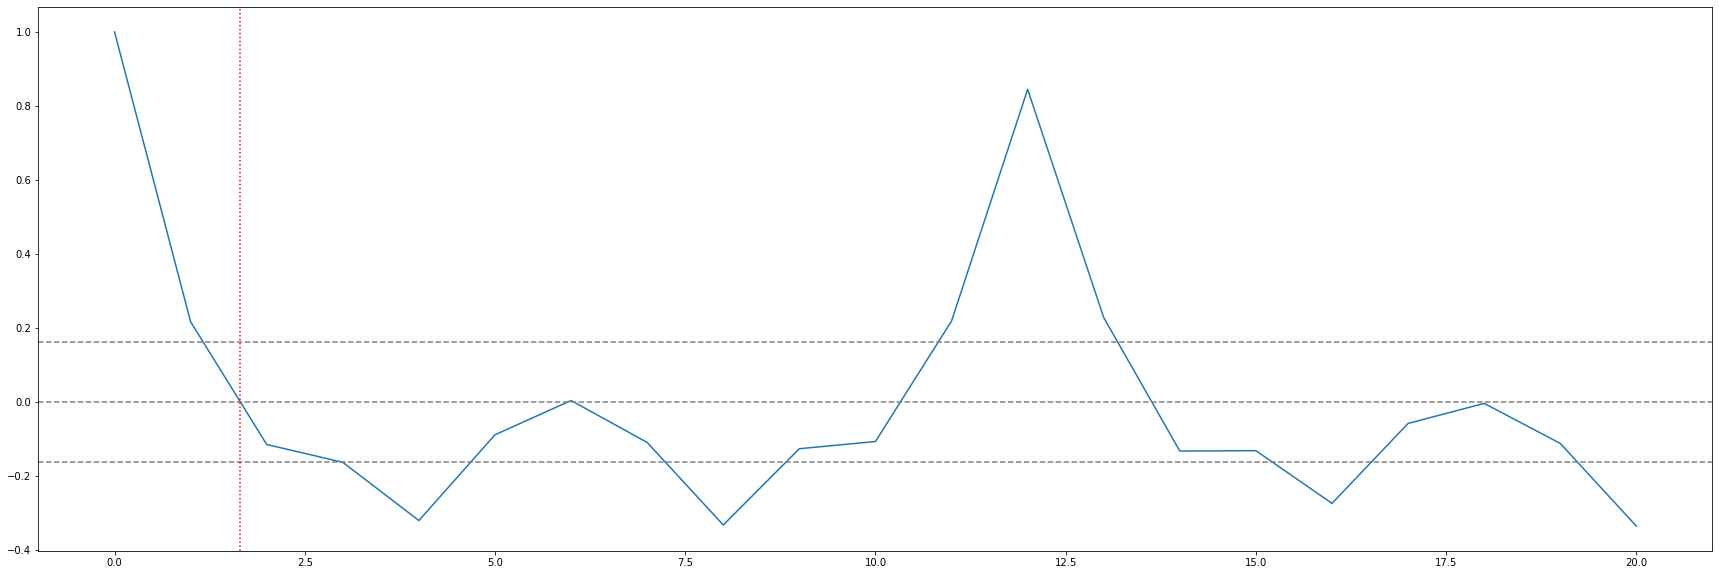

In [7]:
#Plotting an ACF
plt.figure(figsize=(30,10))
lag_acf = acf(df_box_diff, nlags=20,fft=True)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='dashed',c='gray')
#95% of the area under a normal curve lies within roughly 1.96 standard deviations of the mean, and 
#due to the central limit theorem, this number is therefore used in the construction of approximate 95% confidence intervals.
plt.axhline(y=-1.96/np.sqrt(len(df_box_diff)),linestyle='dashed',c='gray')
plt.axhline(y=1.96/np.sqrt(len(df_box_diff)),linestyle='dashed',c='gray')
plt.axvline(x=1.65,linestyle='dotted',c='red')
plt.show()

From the ACF graph, we see that curve touches y=0.0 line at x=1.65. Thus, from theory, q can be either 1 or 2 will be a good starting point

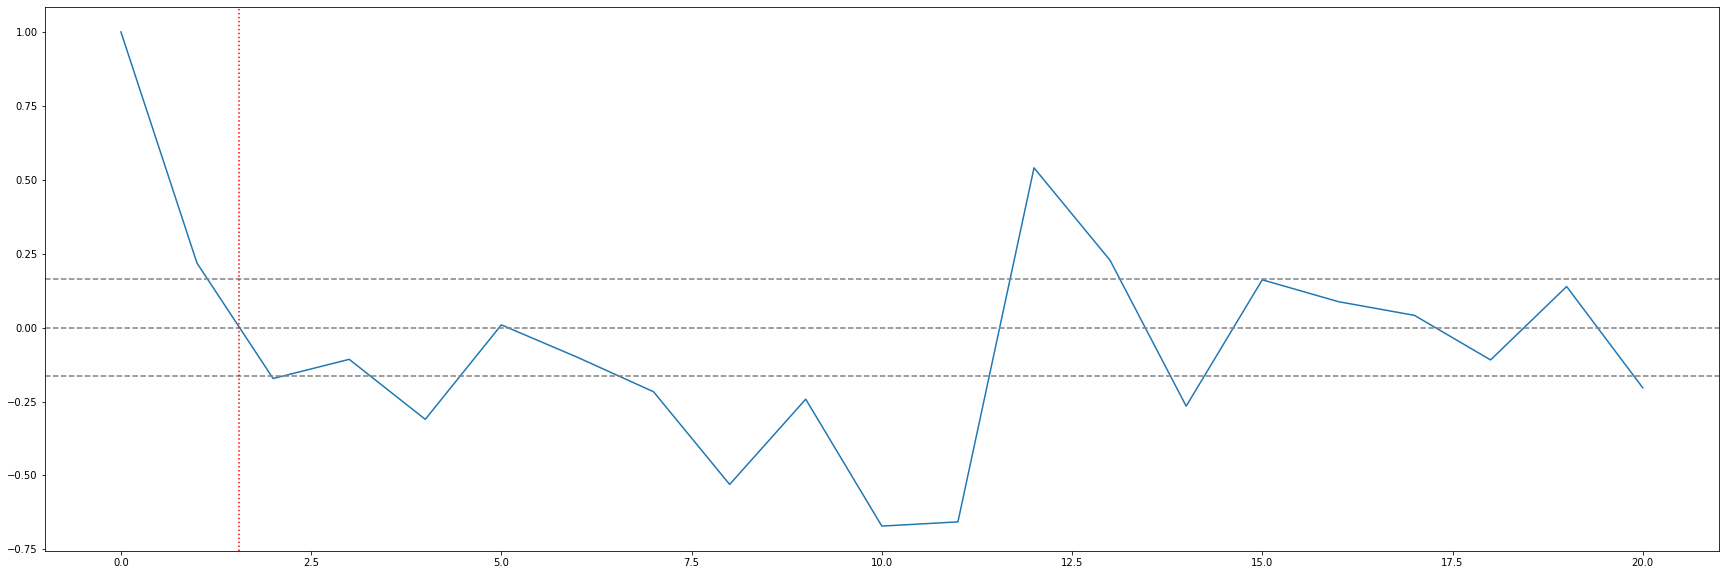

In [8]:
#Plotting an PACF
plt.figure(figsize=(30,10))
lag_pacf = pacf(df_box_diff, nlags=20)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='dashed',c='gray')
#95% of the area under a normal curve lies within roughly 1.96 standard deviations of the mean, and 
#due to the central limit theorem, this number is therefore used in the construction of approximate 95% confidence intervals.
plt.axhline(y=-1.96/np.sqrt(len(df_box_diff)),linestyle='dashed',c='gray')
plt.axhline(y=1.96/np.sqrt(len(df_box_diff)),linestyle='dashed',c='gray')
plt.axvline(x=1.55,linestyle='dotted',c='red')
plt.show()

From the PACF graph, we see that curve touches y=0.0 line at x=1.55. Thus, from theory, p is either 1 or 2 will be a good starting point.

d is the number of nonseasonal differences, i.e. in this case we took the first order difference. <br>
So either we can pass that variable (df_box_diff) and put d=0 or pass the original variable(df_box) and put d=1. <br>
Both will generate same results.
0 or 1 will be a good starting point

### ARIMA Forecasting

In [9]:
#Doing Box cox transformation & differencing
pdf=df.copy()
pdf.columns=['Actual']
df_box_diff,lam,init_val=boxcox_diff(df)
#Buling model & predicting
pdf_box_diff=arima_predict(df_box_diff,1,0,1,summary=True)
#Doing Inverse transformation & differencing
pdf['Predicted']=inv_boxcox_diff(pdf_box_diff,lam,init_val)
pdf

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(1, 0, 1)   Log Likelihood                   7.390
Date:                Tue, 03 Nov 2020   AIC                             -6.781
Time:                        07:06:02   BIC                              5.099
Sample:                    01-31-2003   HQIC                            -1.954
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0215      0.024      0.902      0.367      -0.025       0.068
ar.L1         -0.5719      0.162     -3.531      0.000      -0.889      -0.254
ma.L1          0.8570      0.096      8.938      0.0

,Actual,Predicted
Month,,
2003-01,112,113.0
2003-02,118,114.0
2003-03,132,117.0
2003-04,129,120.0
2003-05,121,118.0
...,...,...
2015-08,606,459.0
2015-09,508,457.0
2015-10,461,442.0


RMSE: 49.3060


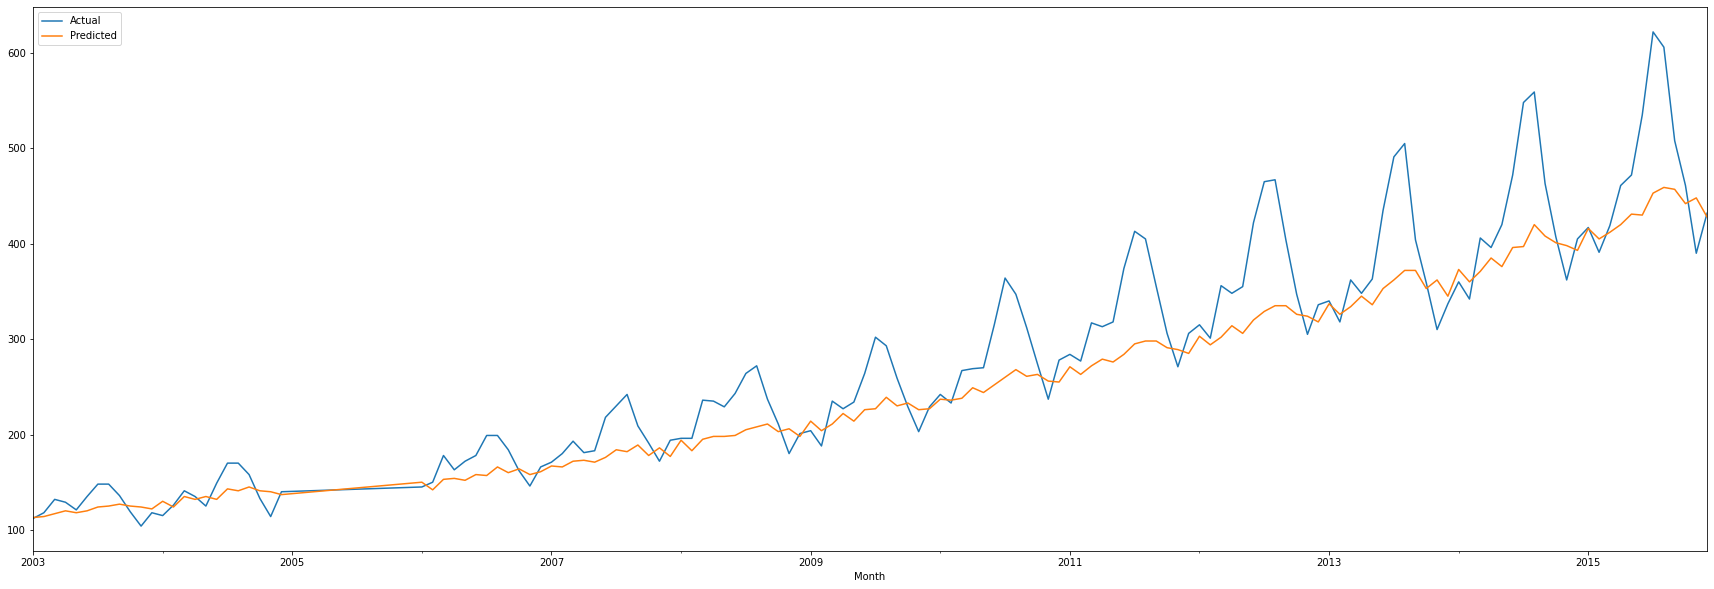

In [10]:
pdf.plot(figsize=(30,10))
print('RMSE: %.4f'% np.sqrt(mean_squared_error(pdf['Actual'],pdf['Predicted'])))

Not looking that good. Our Persistence RMSE was 43.529 in Walk forward validation.

Now Lets try a grid search with different p,d,q values

In [11]:
grid_results=pd.DataFrame(columns=['p','d','q','RMSE'])
#Doing Box cox transformation & differencing
df_box_diff,lam,init_val=boxcox_diff(df)
for p in range(4) :
    for d in range(4) :
        for q in range(4) :
            pdf=df.copy()
            pdf.columns=['Actual']
            #Buling model & predicting
            pdf_box_diff=arima_predict(df_box_diff,p,d,q)
            #Doing Inverse transformation & differencing
            pdf['Predicted']=inv_boxcox_diff(pdf_box_diff,lam,init_val)
            grid_results.loc[len(grid_results)]=[p,d,q,np.sqrt(mean_squared_error(pdf['Actual'],pdf['Predicted']))]
            #print('p={} d={} q={} RMSE={}'.format(p,d,q,np.sqrt(mean_squared_error(pdf['Actual'],pdf['Predicted']))))           
grid_results

,p,d,q,RMSE
0,0.0,0.0,0.0,61.080321
1,0.0,0.0,1.0,46.460333
2,0.0,0.0,2.0,54.937780
3,0.0,0.0,3.0,159.272892
4,0.0,1.0,0.0,33.593154
...,...,...,...,...
59,3.0,2.0,3.0,41.966587
60,3.0,3.0,0.0,53.073717
61,3.0,3.0,1.0,68.370468
62,3.0,3.0,2.0,84.693893


In [12]:
grid_results.sort_values('RMSE',axis=0).head(10)

,p,d,q,RMSE
4,0.0,1.0,0.0,33.593154
20,1.0,1.0,0.0,37.630421
43,2.0,2.0,3.0,39.530842
11,0.0,2.0,3.0,39.633652
8,0.0,2.0,0.0,39.870885
36,2.0,1.0,0.0,40.217205
41,2.0,2.0,1.0,40.645230
52,3.0,1.0,0.0,40.773170
57,3.0,2.0,1.0,41.084601
58,3.0,2.0,2.0,41.879291


Seems like an ARIMA(0,1,0) yields the best RMSE. A random walk.

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -32.691
Date:                Tue, 03 Nov 2020   AIC                             67.382
Time:                        07:06:29   BIC                             70.345
Sample:                    01-31-2003   HQIC                            68.586
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0925      0.013      7.368      0.000       0.068       0.117
Ljung-Box (L1) (Q):                  11.29   Jarque-Bera (JB):                 5.44
Prob(Q):                              0.00   Pr

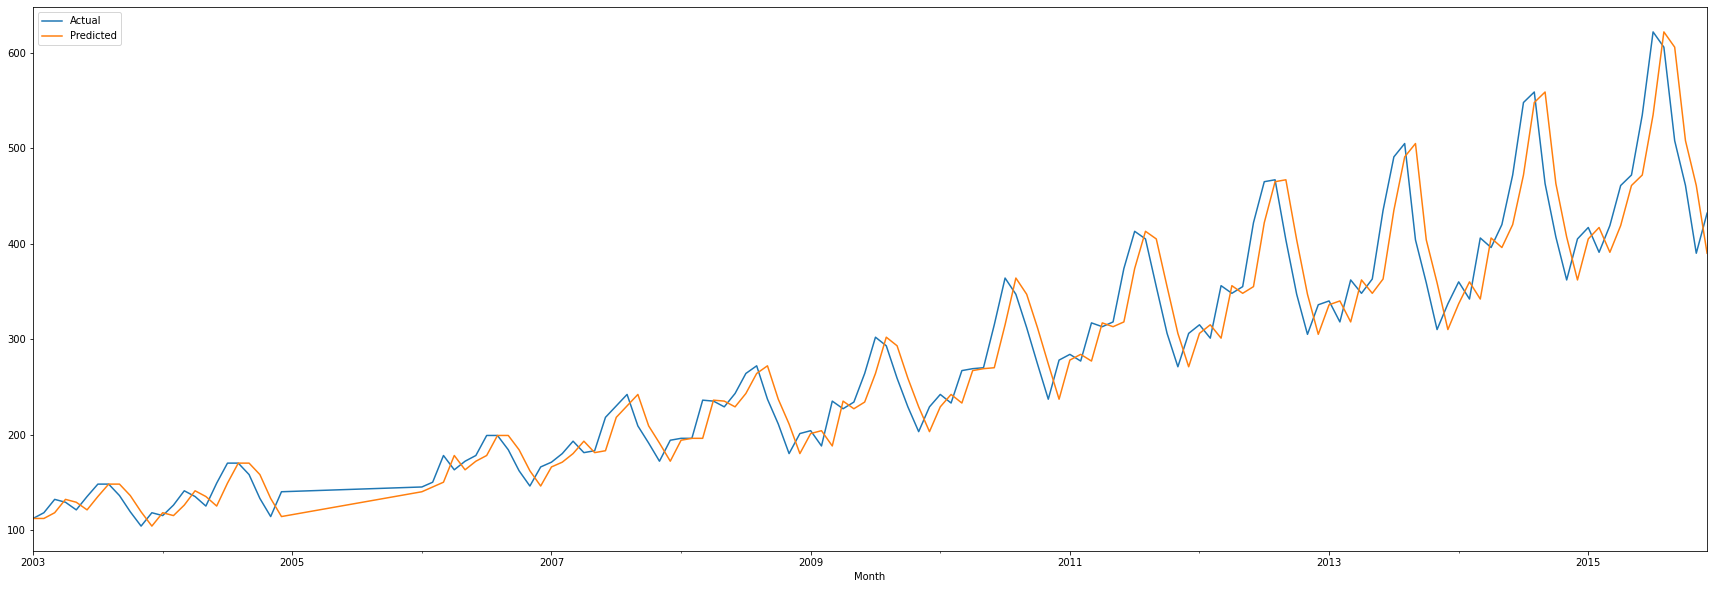

RMSE: 33.5932


In [13]:
#Doing Box cox transformation & differencing
pdf=df.copy()
pdf.columns=['Actual']
df_box_diff,lam,init_val=boxcox_diff(df)
#Buling model & predicting
pdf_box_diff=arima_predict(df_box_diff,0,1,0,summary=True)
#Doing Inverse transformation & differencing
pdf['Predicted']=inv_boxcox_diff(pdf_box_diff,lam,init_val)
pdf
pdf.plot(figsize=(30,10))
plt.show()
print('RMSE: %.4f'% np.sqrt(mean_squared_error(pdf['Actual'],pdf['Predicted'])))

In [14]:
pdf

,Actual,Predicted
Month,,
2003-01,112,112.0
2003-02,118,112.0
2003-03,132,118.0
2003-04,129,132.0
2003-05,121,129.0
...,...,...
2015-08,606,622.0
2015-09,508,606.0
2015-10,461,508.0


This looks to be some what a good prediction

Now we can try the WALK FORWARD validation. So, we will have to use a mathematical transformation.
We may not get correct resultsif we use the differencing as it will need a full distribution to take the shifting, cumulative sum, etc. 

So, Lets use log transformation as it yielded better p valye and ADF stat. (pls refer Explanatory Data Analysis notebook for more insight)

In [15]:
# First doing a grid search to find best p,d,q for log transformed data
grid_results_log=pd.DataFrame(columns=['p','d','q','RMSE'])
#Doing log transformation 
df_log=np.log(df)
for p in range(4) :
    for d in range(4) :
        for q in range(4) :
            pdf=df.copy()
            pdf.columns=['Actual']
            #Buling model & predicting
            pdf_log=arima_predict(df_log,p,d,q)
            #Doing Inverse transformation
            pdf['Predicted']=np.exp(pdf_log)
            grid_results_log.loc[len(grid_results_log)]=[p,d,q,np.sqrt(mean_squared_error(pdf['Actual'],pdf['Predicted']))]
            #print('p={} d={} q={} RMSE={}'.format(p,d,q,np.sqrt(mean_squared_error(pdf['Actual'],pdf['Predicted']))))           
grid_results_log.sort_values('RMSE',axis=0).head(20)

,p,d,q,RMSE
55,3.0,1.0,3.0,27.484993
54,3.0,1.0,2.0,30.428873
53,3.0,1.0,1.0,30.903159
37,2.0,1.0,1.0,30.969127
39,2.0,1.0,3.0,31.038881
38,2.0,1.0,2.0,31.406974
23,1.0,1.0,3.0,31.423977
22,1.0,1.0,2.0,31.426514
35,2.0,0.0,3.0,31.527479
51,3.0,0.0,3.0,31.672005


We got ARIMA(3,1,3) the best RMSE 27.48 which is even better than the box cox transformed one with differencing.


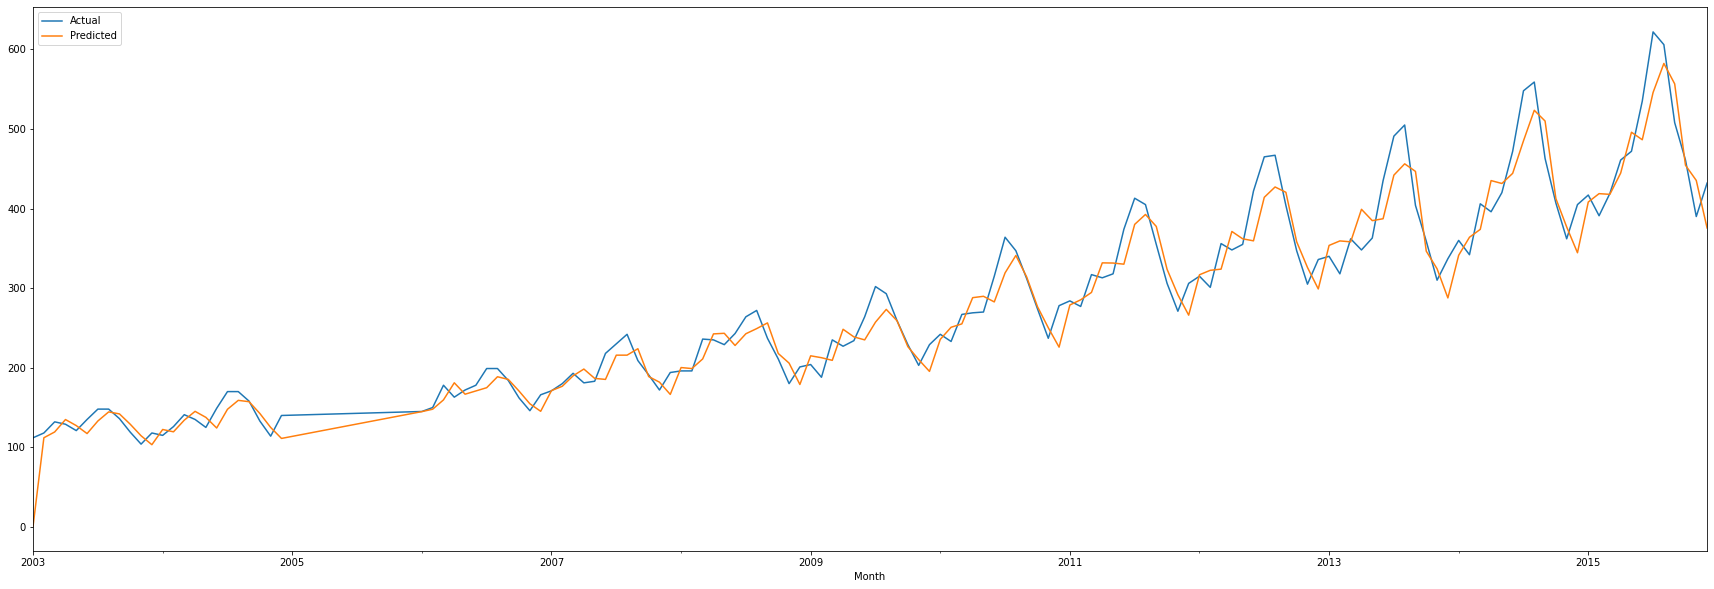

RMSE: 27.4850


In [16]:
#Doing log transformation
pdf=df.copy()
pdf.columns=['Actual']
df_log=np.log(df)
#Buling model & predicting
pdf_log=arima_predict(df_log,3,1,3)
#Doing Inverse transformation
pdf['Predicted']=np.exp(pdf_log)
pdf
pdf.plot(figsize=(30,10))
plt.show()
print('RMSE: %.4f'% np.sqrt(mean_squared_error(pdf['Actual'],pdf['Predicted'])))


Now lets try the Walk forward validation on this.

### Walk Forward Validation

In [17]:
X=df['#Passengers'].values
#We can split the data to train & split on a pecentage basis as below.
#Splitting for train (70%) & Test (30%)
train_size = int(len(X) * 0.70)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    #Transform
    history_l=np.log(history)
    # predict
    model = ARIMA(history_l, order=(3,1,3))
    model_fit = model.fit()
    yhat_l = model_fit.forecast()[0]
    #reverse transform
    yhat=np.exp(yhat_l)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    
# report performance
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=359.805, Expected=355
>Predicted=355.451, Expected=422
>Predicted=408.983, Expected=465
>Predicted=430.472, Expected=467
>Predicted=430.110, Expected=404
>Predicted=360.934, Expected=347
>Predicted=330.521, Expected=305
>Predicted=299.433, Expected=336
>Predicted=351.487, Expected=340
>Predicted=364.154, Expected=318
>Predicted=354.560, Expected=362
>Predicted=394.684, Expected=348
>Predicted=376.857, Expected=363
>Predicted=389.508, Expected=435
>Predicted=454.202, Expected=491
>Predicted=473.235, Expected=505
>Predicted=465.817, Expected=404
>Predicted=354.926, Expected=359
>Predicted=327.615, Expected=310
>Predicted=286.927, Expected=337
>Predicted=344.135, Expected=360
>Predicted=356.419, Expected=342
>Predicted=363.240, Expected=406
>Predicted=414.012, Expected=396
>Predicted=411.906, Expected=420
>Predicted=422.256, Expected=472
>Predicted=468.048, Expected=548
>Predicted=524.663, Expected=559
>Predicted=517.493, Expected=463
>Predicted=414.211, Expected=407
>Predicted

Wlak forward validation also gives a some what okey RMSE.

Now lets try plotting them.

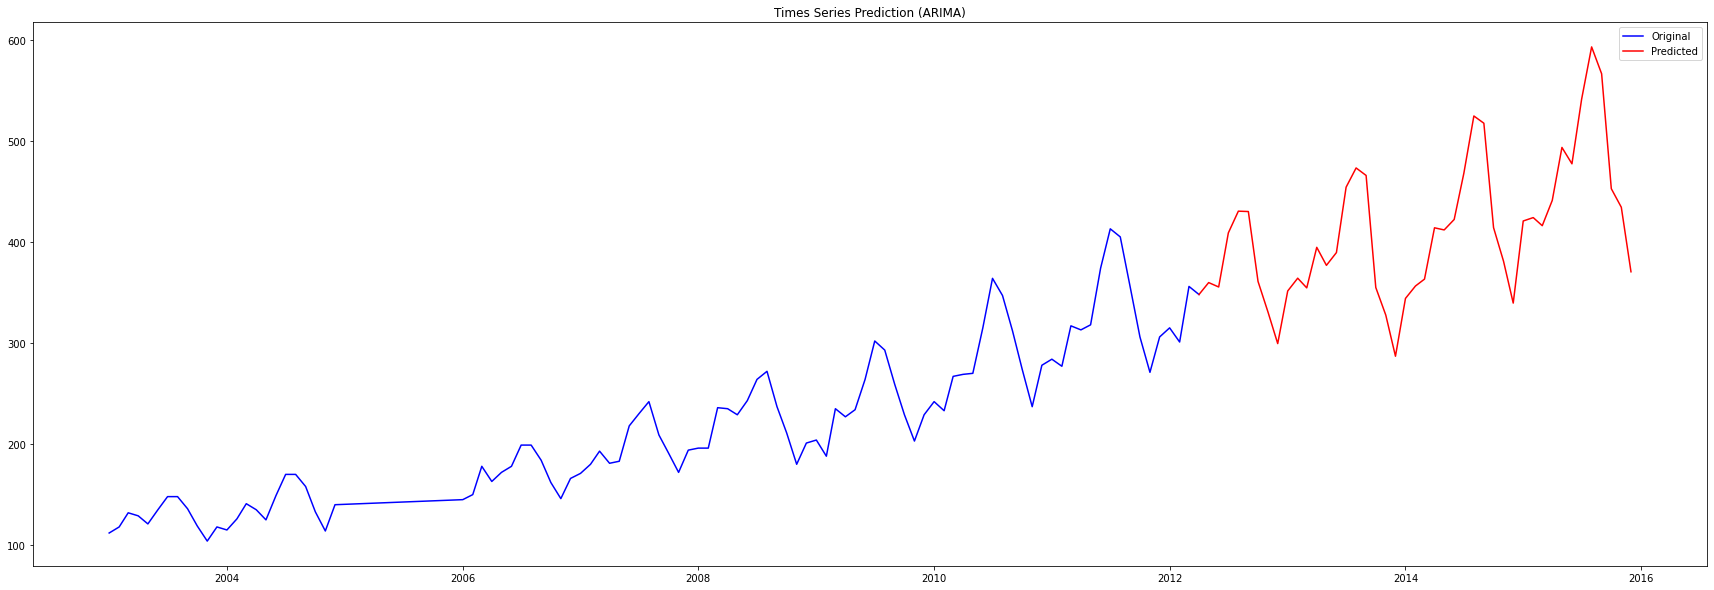

In [18]:
train_list = [x for x in train]
t1_df=df.copy()
t1_df.iloc[:,0]=train_list + predictions
t2_df=t1_df.to_timestamp()
plt.figure(figsize=(30,10))
#Color blue for training data
plt.plot(t2_df.iloc[:train_size,0],c='b',label='Original')
#Color red for predicted data
plt.plot(t2_df.iloc[train_size-1:,0],c='r',label='Predicted')
plt.title("Times Series Prediction (ARIMA)")
plt.legend()
plt.show()

# Auto ARIMA

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
%matplotlib inline
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore")

Lets try an Auto Arima search similar to the grid search we did in ARIMA.
We will use a similar range from 0 to 4 for p,q & P,Q.(Its using SARIMA internally)
I am not playing around with d & D.

In [20]:
df=pd.read_csv('SeaPlaneTravel.csv')
df.Month=pd.to_datetime(df.Month)
df.set_index('Month',inplace=True)
df.index = pd.DatetimeIndex(df.index).to_period('M')
#Doing log transformation
df_log=np.log(df)

In [21]:
# Fit auto_arima function to log transformed Passengers data
stepwise_fit = auto_arima(df_log['#Passengers'], 
                          start_p = 0, max_p = 4, 
                          start_q = 0, max_q = 4, 
                          d = None, 
                          start_P = 0, max_P = 4,
                          start_Q = 0, max_Q = 4,
                          D = 1,
                          m = 12, 
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',    # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-358.005, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-472.836, Time=1.54 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-423.080, Time=1.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-152.756, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-452.647, Time=0.35 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-476.268, Time=3.15 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=-477.966, Time=4.27 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=-477.905, Time=6.30 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=-475.187, Time=3.80 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-476.225, Time=1.83 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=-474.573, Time=7.88 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=-381.464, Time=3.61 sec
 ARIMA(2,0,0)(3,1,0)[12] intercept   : AIC=-486.555, Time=4.65 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-484.457, Time=2.70 sec
 ARIMA(2,0,0)(4,1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(3, 1, 0, 12)   Log Likelihood                 250.278
Date:                            Tue, 03 Nov 2020   AIC                           -486.555
Time:                                    07:09:06   BIC                           -466.376
Sample:                                         0   HQIC                          -478.355
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0410      0.018      2.308      0.021       0.006       0.076
ar.L1          0.5529      0.078      7.083      0.000       0.400       0.706
ar.L2          0.2797      0.085      3.284      0.001       0.113       0.447
ar.S.L12      -0.5635      0.104     -5.401      0.000      -0.768      -0.359
ar.S.L24      -0.2892      0.140     -2.061      0.039      -0.564      -0.014
ar.S.L36      -0.2094      0.117     -1.790      0.073      -0.439       0.020
sigma2         0.0013      0.000      9.115      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 6.92
Prob(Q):                              0.85   Prob(JB):                         0.03
Heteroskedasticity (H):               0.59   Skew:                             0.07
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So, the best mdoel it identifies is ARIMA(2,0,0)(3,1,0)[12] <br>
Lets try predicting using the same

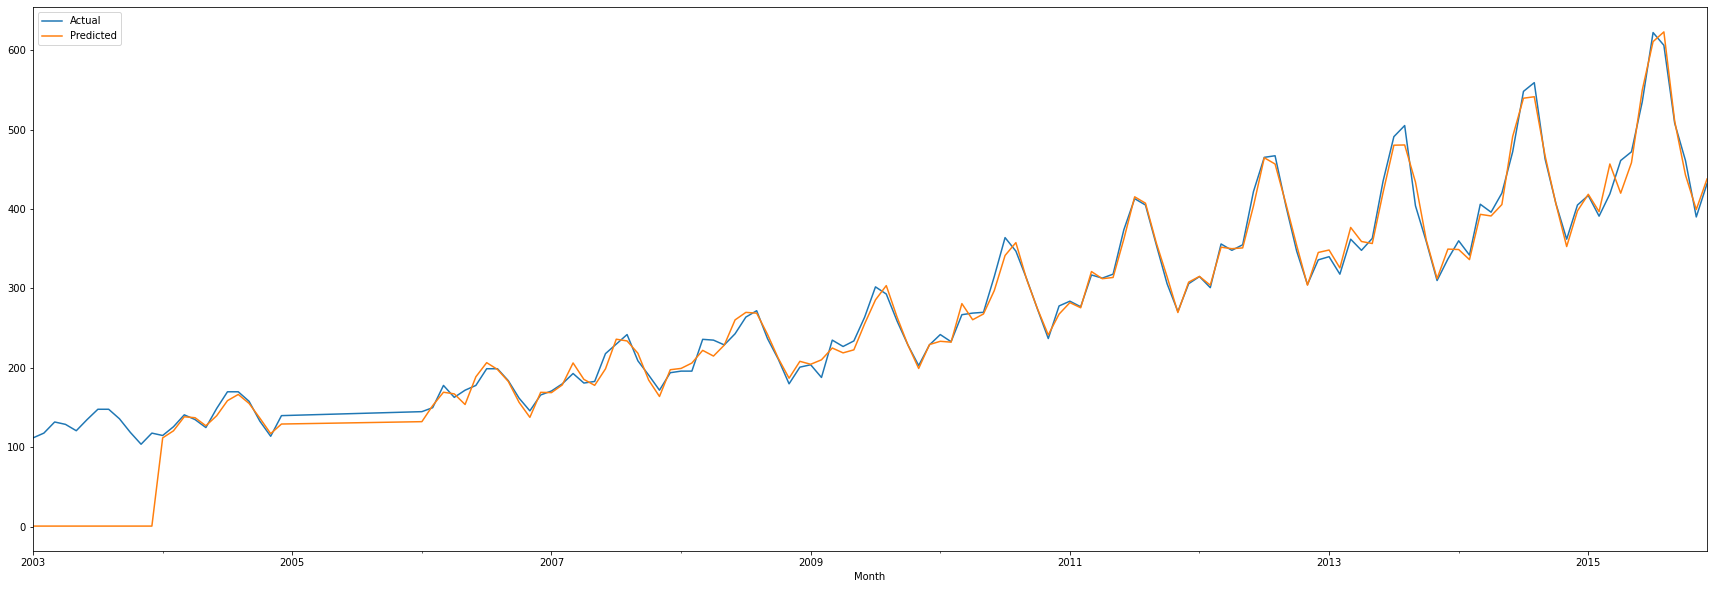

RMSE: 37.9050


In [22]:
#Doing log transformation
pdf=df.copy()
pdf.columns=['Actual']
df_log=np.log(df)
#Buling model & predicting
model = SARIMAX(df_log['#Passengers'],  
                order = (2, 0, 0),  
                seasonal_order =(3, 1, 0, 12)) 
result = model.fit() 
pdf_log=result.predict()
#Doing Inverse transformation
pdf['Predicted']=np.exp(pdf_log)
pdf.plot(figsize=(30,10))
plt.show()
print('RMSE: %.4f'% np.sqrt(mean_squared_error(pdf['Actual'],pdf['Predicted'])))

Thats not bad at all. With auto arima we were quickly able to reach to a some what good model.

We can try a walk forward validation as well.

In [23]:
X=df['#Passengers'].values
#We can split the data to train & split on a pecentage basis as below.
#Splitting for train (70%) & Test (30%)
train_size = int(len(X) * 0.70)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    #Transform
    history_l=np.log(history)
    # predict
    model = SARIMAX(history_l, order=(2, 0, 0), seasonal_order=(3, 1, 0, 12)) 
    model_fit = model.fit()
    yhat_l = model_fit.forecast() # SARIMAX forecast returns only 1 step.
    #reverse transform
    yhat=np.exp(yhat_l)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    
# report performance
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=351.103, Expected=355
>Predicted=403.435, Expected=422
>Predicted=467.388, Expected=465
>Predicted=456.833, Expected=467
>Predicted=408.003, Expected=404
>Predicted=355.105, Expected=347
>Predicted=304.769, Expected=305
>Predicted=344.694, Expected=336
>Predicted=348.895, Expected=340
>Predicted=326.166, Expected=318
>Predicted=377.203, Expected=362
>Predicted=358.923, Expected=348
>Predicted=355.944, Expected=363
>Predicted=421.269, Expected=435
>Predicted=481.780, Expected=491
>Predicted=480.049, Expected=505
>Predicted=434.162, Expected=404
>Predicted=359.418, Expected=359
>Predicted=311.729, Expected=310
>Predicted=347.604, Expected=337
>Predicted=348.029, Expected=360
>Predicted=336.086, Expected=342
>Predicted=393.208, Expected=406
>Predicted=392.010, Expected=396
>Predicted=405.791, Expected=420
>Predicted=492.379, Expected=472
>Predicted=539.051, Expected=548
>Predicted=541.553, Expected=559
>Predicted=464.838, Expected=463
>Predicted=405.739, Expected=407
>Predicted

### Thats really cool. RMSE 14.453. The best we got so far :-)

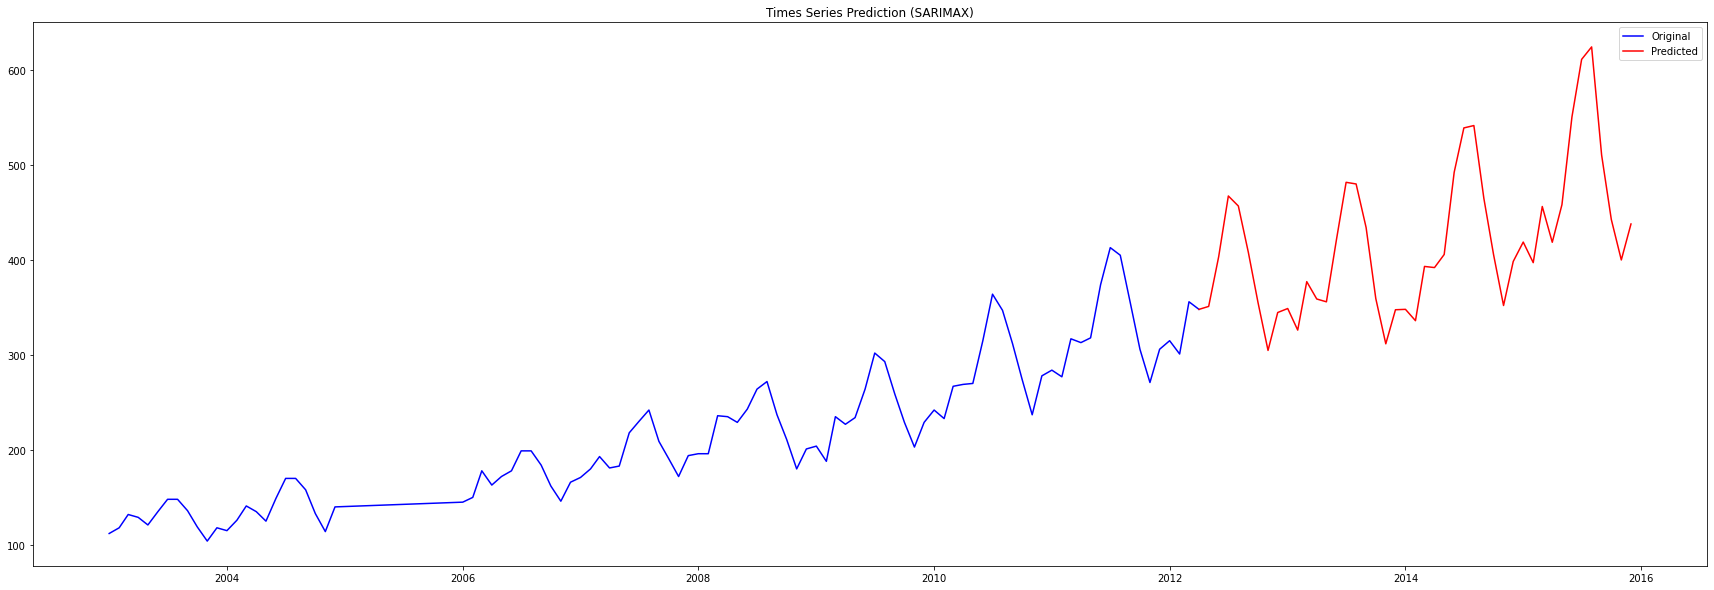

In [24]:
train_list = [x for x in train]
t1_df=df.copy()
t1_df.iloc[:,0]=train_list + predictions
t2_df=t1_df.to_timestamp()
plt.figure(figsize=(30,10))
#Color blue for training data
plt.plot(t2_df.iloc[:train_size,0],c='b',label='Original')
#Color red for predicted data
plt.plot(t2_df.iloc[train_size-1:,0],c='r',label='Predicted')
plt.title("Times Series Prediction (SARIMAX)")
plt.legend()
plt.show()